https://colab.research.google.com/drive/1oFh1y9XAQymU8ga8lGPz3MozxDAn7LhA

# Step 7 : Fix the Model Capacity

_"The Capacity to learn is a **Gift**, the Ability to learn is a **Skill**, the Willingness to learn is a **Choice**"_    --Successful Student

Target:

1. Fix the model capacities in the middle layer.
2. Don't bake the cake unless you have so many features to capture. Increase, Decrease, Increase cycle.
3. Result:
    1. Parameters: 7.5k
    2. Best Train Accuracy: 99.14
    3. Best Test Accuracy: 99.35
4. Analysis:
    1. Quite Possibly we need to add more capacity, especially at the end.
    2. Closer analysis of MNIST can also reveal that just at RF of 5x5 we start to see patterns forming.
    3. We can also increase the capacity of the model by **adding a layer after GAP!**

## 1. Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## 2. Calculate Mean & Standard Deviation of Raw Data to Normalize the Input Data/Tensor Later

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

C:\ProgramData\anaconda3\envs\python39\lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## 3.1 Record Some Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
cuda = torch.cuda.is_available()

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(exp, **dataloader_args)

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])


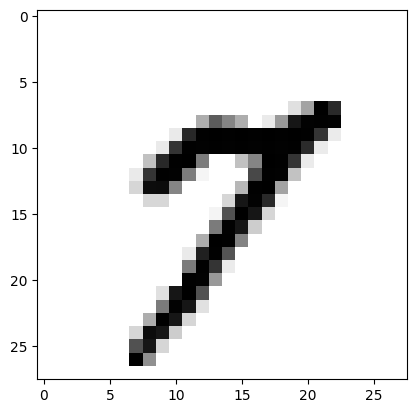

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = exp.train_data
train_data = exp.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## 3.2 A Bit MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

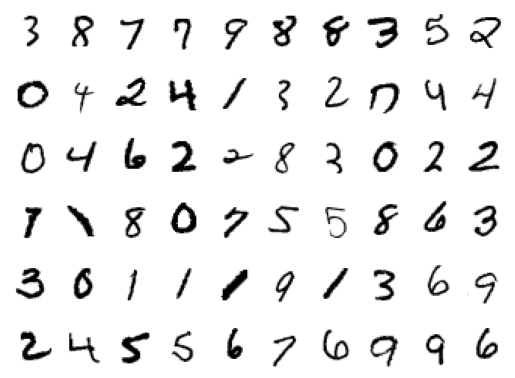

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## 4. Define your NN Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05)
        ) # X in-out = 28-26 | J in-out = 1-1 | R.F in-out = 1-3 |  | Channels in-out = 1-8

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        ) # X in-out = 26-24 | J in-out = 1-1 | R.F in-out = 3-5 | Channels in-out = 8-16


        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # X in-out = 24-12 | J in-out = 1-2 | R.F in-out = 5-6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05)
        ) # X in-out = 12-12 | J in-out = 2-2 | R.F in-out = 6-6 | Channels in-out = 16-8

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        ) # X in-out = 12-10 | J in-out = 2-2 | R.F in-out = 6-10 | Channels in-out = 8-16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        ) # X in-out = 10-8 | J in-out = 2-2 | R.F in-out = 10-14 | Channels in-out = 16-16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        ) # X in-out = 8-6 | J in-out = 2-2 | R.F in-out = 14-18 | Channels in-out = 16-16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)
        ) # X in-out = 5-5 | J in-out = 2-2 | R.F in-out = 20-20 | Channels in-out = 32-64
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # X in-out = 1-1 | J in-out = 2-2 | R.F in-out = 22-22

        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        # INPUT BLOCK
        x = self.convblock1(x)

        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)

        # MAXPOOL 1
        x = self.pool1(x)
        x = self.convblock3(x)

        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)

        # OUTPUT BLOCK
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)

## 5. Observe the Model Parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
      BatchNorm2d-12            [-1, 8, 12, 12]              16
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

## 6. SEED - finish randomness of PyTorch

Before we start training, get rid of PyTorch SEED Issue

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


## 7. Import & Define Train/Test Data with Normalized Tensors

1.   Define Appropriate Transformations
2.   Apply the Transformations to Input Dataset - both Train & Test


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## 8. Create Dataset Batches

In [ ]:

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

## 9. Define Training and Testing Methods for Neural Network

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## 10. Run, Train and Test the Model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.16952045261859894 Batch_id=468 Accuracy=89.76: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.18it/s]



Test set: Average loss: 0.1157, Accuracy: 9797/10000 (97.97%)

EPOCH: 1


Loss=0.13960139453411102 Batch_id=468 Accuracy=97.75: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.83it/s]



Test set: Average loss: 0.0717, Accuracy: 9841/10000 (98.41%)

EPOCH: 2


Loss=0.11516255140304565 Batch_id=468 Accuracy=98.12: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.93it/s]



Test set: Average loss: 0.0627, Accuracy: 9856/10000 (98.56%)

EPOCH: 3


Loss=0.058900635689496994 Batch_id=468 Accuracy=98.38: 100%|█████████████████████████| 469/469 [00:18<00:00, 25.29it/s]



Test set: Average loss: 0.0472, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.0834139958024025 Batch_id=468 Accuracy=98.52: 100%|███████████████████████████| 469/469 [00:16<00:00, 28.94it/s]



Test set: Average loss: 0.0376, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.03739284351468086 Batch_id=468 Accuracy=98.61: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.45it/s]



Test set: Average loss: 0.0342, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.04661872982978821 Batch_id=468 Accuracy=98.71: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.84it/s]



Test set: Average loss: 0.0347, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.06921230256557465 Batch_id=468 Accuracy=98.78: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.69it/s]



Test set: Average loss: 0.0319, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.06091943010687828 Batch_id=468 Accuracy=98.83: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.64it/s]



Test set: Average loss: 0.0329, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.024530040100216866 Batch_id=468 Accuracy=98.85: 100%|█████████████████████████| 469/469 [00:16<00:00, 29.13it/s]



Test set: Average loss: 0.0315, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.021170714870095253 Batch_id=468 Accuracy=98.88: 100%|█████████████████████████| 469/469 [00:16<00:00, 28.63it/s]



Test set: Average loss: 0.0307, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.02241937257349491 Batch_id=468 Accuracy=98.92: 100%|██████████████████████████| 469/469 [00:16<00:00, 29.01it/s]



Test set: Average loss: 0.0278, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.04243334010243416 Batch_id=468 Accuracy=99.00: 100%|██████████████████████████| 469/469 [00:17<00:00, 27.54it/s]



Test set: Average loss: 0.0299, Accuracy: 9912/10000 (99.12%)

EPOCH: 13


Loss=0.03657780587673187 Batch_id=468 Accuracy=98.97: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.21it/s]



Test set: Average loss: 0.0259, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.02474408596754074 Batch_id=468 Accuracy=99.00: 100%|██████████████████████████| 469/469 [00:24<00:00, 18.84it/s]



Test set: Average loss: 0.0280, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.03314227983355522 Batch_id=468 Accuracy=99.03: 100%|██████████████████████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)

EPOCH: 16


Loss=0.032983552664518356 Batch_id=468 Accuracy=99.04: 100%|█████████████████████████| 469/469 [00:19<00:00, 24.67it/s]



Test set: Average loss: 0.0238, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.012290253303945065 Batch_id=468 Accuracy=99.07: 100%|█████████████████████████| 469/469 [00:19<00:00, 24.12it/s]



Test set: Average loss: 0.0243, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.04481028392910957 Batch_id=468 Accuracy=99.07: 100%|██████████████████████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0238, Accuracy: 9924/10000 (99.24%)

EPOCH: 19


Loss=0.02125716209411621 Batch_id=468 Accuracy=99.14: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.85it/s]



Test set: Average loss: 0.0246, Accuracy: 9921/10000 (99.21%)



Text(0.5, 1.0, 'Test Accuracy')

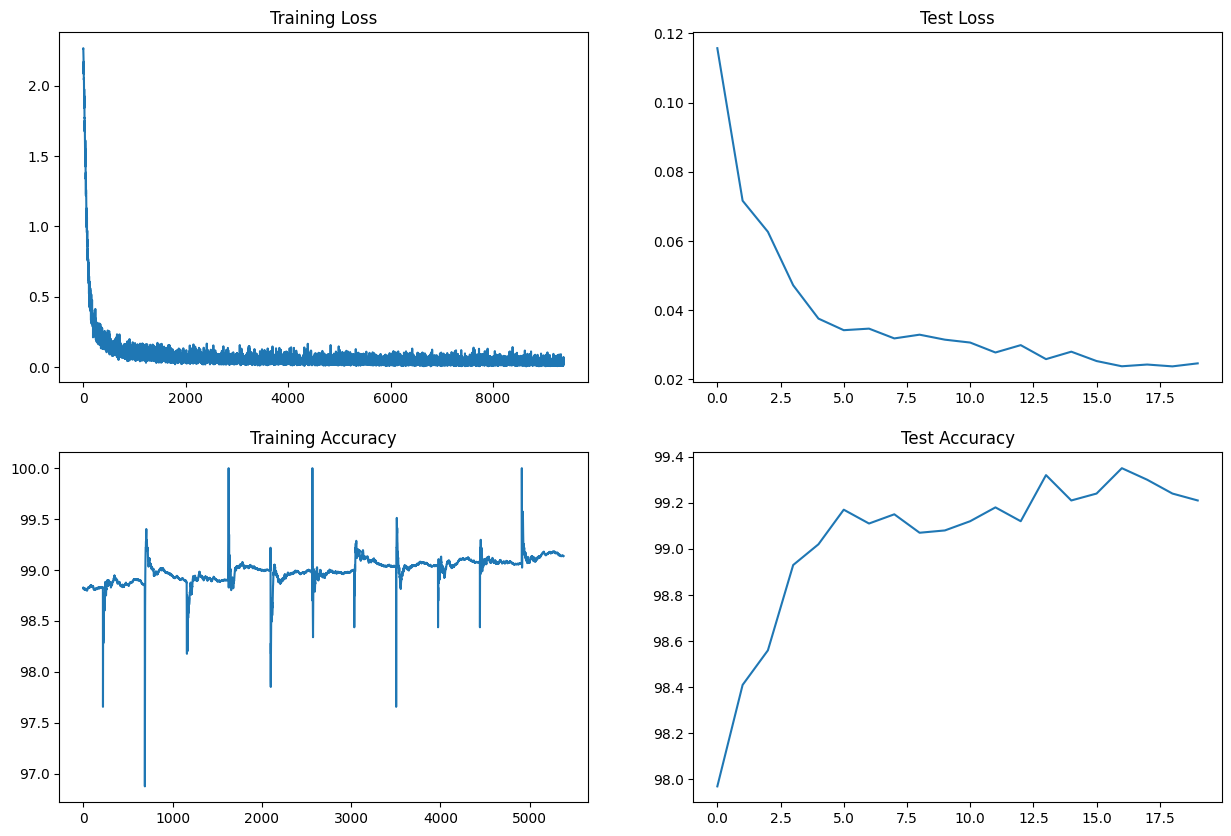

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")